# **Brain Tumor MRI Classification - Simplified Class Activity**
#### **Overview**
This Jupyter Notebook guides students step by step on how to:
1. Import libraries
2. Download the dataset.
3. Load a **pre-trained model** for brain tumor classification.
4. Preprocess MRI images.
5. Make predictions using the model.
6. Visualize the machine learning workflow.

---

Credit/ Licenbse: This notebook was adapted from the work of MD.FARHAD REZA at Kaggle. A version of this Notebook has been released under the Apache 2.0 open source license.

<font color='red'>NOTE: BEFORE USING THIS NOTEBOOK YOU NEED TO DOWNLOAD THE brain_tumor_model.h5 FILE FROM CANVAS AND UPLOAD IT TO THE ML Class Activity folder!</font>

## **🔹 Step 1: Import Libraries**
Note: -
1. Kagglehub is used to extract the preexisting data
2. Tensorflow and Sklearn are one of the most common machine learning packages. Another, one is Pytorch.
3. For simplicity, I have places some pre-made functions in the module "brain_tumor_utils.py"

In [ ]:
# You only need to run this once!
!pip install kagglehub
!pip install tensorflow

In [1]:
import os
import kagglehub
import pickle
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

from brain_tumor_utils import  train_df, test_df, build_model, predict, get_preprocessed_data, plot_one_image_per_class

2025-03-04 18:15:54.300943: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 18:15:54.512222: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 18:15:54.704171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741112154.901328     418 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741112154.960940     418 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 18:15:55.393629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## **🔹 Step 2: Download and Visualize the Dataset**

### 2.1 Download the existing data 

We'll use kagglehub to automatically download the latest version of the dataset. Here is the link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

In [2]:
# Download latest version of the dataset
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:02<00:00, 76.3MB/s] 

Extracting files...


Path to dataset files: /home/ajuavine/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


### 2.2 Training and Testing Data

The data is divided into two folders. Training and Testing. We will use training to train the model and then later test it using new images from the testing folder. This way its a true test of the model. 

In [3]:
# Loading training and testing data
tr_df = train_df(path + '/Training')
ts_df = test_df(path + '/Testing')

print(tr_df.head())
print(ts_df.head())

                                          Class Path       Class
0  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
1  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
2  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
3  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
4  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
                                          Class Path       Class
0  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
1  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
2  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
3  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma
4  /home/ajuavine/.cache/kagglehub/datasets/masou...  meningioma


### 2.3 Visualizing the data

Let's check what kind of images we have! The plot will show you how many images are available for each kind of tumor. 

## Class Activity #1 - Visualize the given data

From the previous step, you have seen the structure of tr_df and ts_df. These DataFrames contain two columns:
1. “Class Path” – provides the file path to the patient’s MRI image.
2. “Class” – indicates the type of tumor.

We will use these DataFrames to create a bar graph that shows the number of images available for each tumor class. Your task is to complete the missing code to count the number of images per class. Replace ??? with the correct Pandas function to count the occurrences of each tumor class.

💡 Hints
1. Use value_counts() on the "Class" column to get the counts.
2. .index gives the class labels.
3. .values gives the counts.


In [7]:
# Count occurrences of each class in training data
train_counts = tr_df['Class'].value_counts().values
train_classes = tr_df['Class'].value_counts().index
print(train_counts)
print(train_classes)

# Count occurrences of each class in testing data
test_counts = ts_df['Class'].value_counts().values 
test_classes = ts_df['Class'].value_counts().index 
print(test_counts)
print(test_classes)

[1595 1457 1339 1321]
Index(['notumor', 'pituitary', 'meningioma', 'glioma'], dtype='object', name='Class')
[405 306 300 300]
Index(['notumor', 'meningioma', 'glioma', 'pituitary'], dtype='object', name='Class')


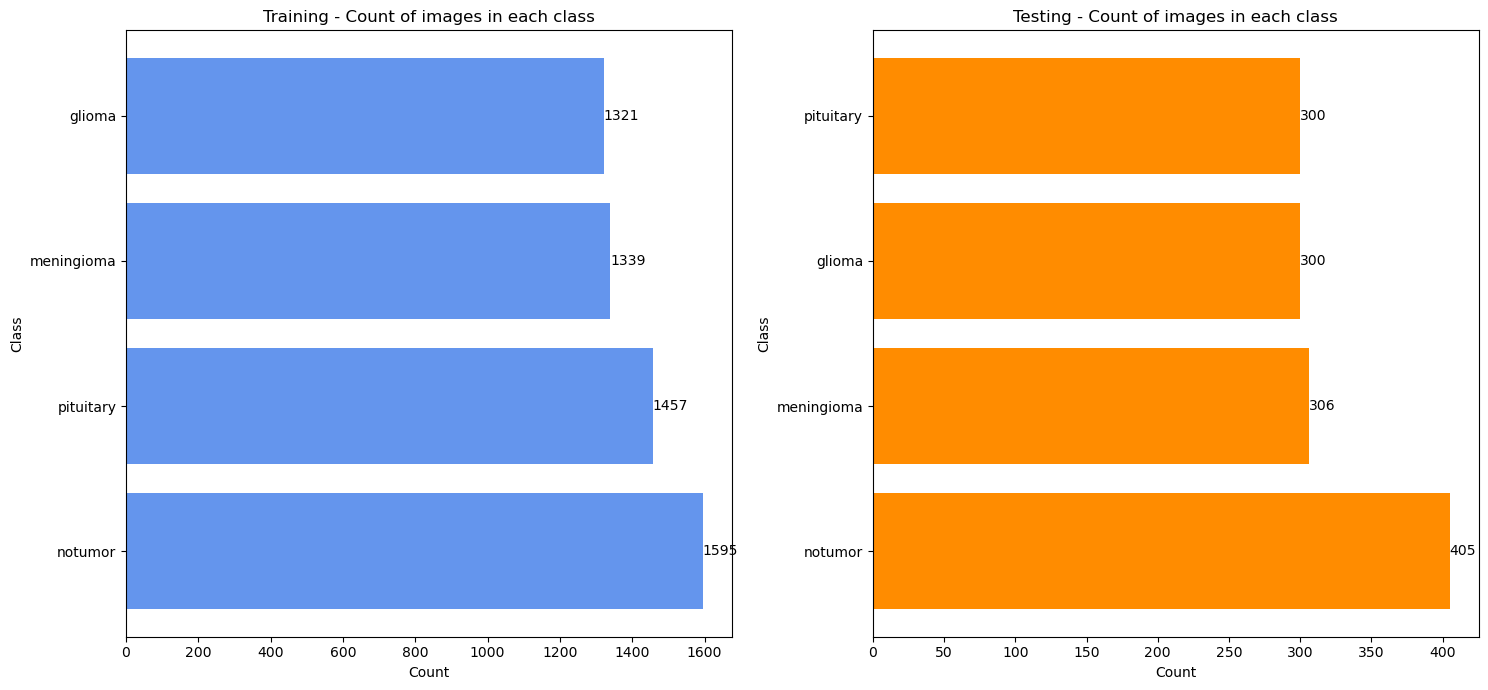

In [8]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Training Data Class Distribution
axes[0].barh(train_classes, train_counts, color='cornflowerblue')
axes[0].set_title('Training - Count of images in each class')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Class')

# Add labels on bars
for index, value in enumerate(train_counts):
    axes[0].text(value, index, str(value), va='center')

# Testing Data Class Distribution
axes[1].barh(test_classes, test_counts, color='darkorange')
axes[1].set_title('Testing - Count of images in each class')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Class')

# Add labels on bars
for index, value in enumerate(test_counts):
    axes[1].text(value, index, str(value), va='center')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 2.4 Spilt the testing data so we can have testing and validation dataset

In machine learning, splitting the dataset is essential to evaluate the model’s performance and ensure it generalizes well to new data. The reason for splitting ts_df into valid_df and ts_df again is to create a validation set if one is missing.

Note:-
1. Training Set (tr_df) → Used to train the model.
2. Validation Set (valid_df) → Used to tune the model and prevent overfitting.
3. Test Set (ts_df) → Used to evaluate final model performance on unseen data.

Explanation of Parameters: - 
1. ts_df → The original dataset that we want to split.
2. train_size=0.5 → 50% of ts_df will be used for validation (valid_df), and the remaining 50% stays in ts_df as the test set.
3. random_state=20 → Ensures the split is reproducible (i.e., every time you run it, you get the same split).
4. stratify=ts_df['Class'] → Ensures the split preserves the class distribution.

In [10]:
print(ts_df.shape) # original number of images in test dataframe

(1311, 2)


We have created a function that spilts the testing dataset into validation and testing data. 

Note: Everytime you call this function it will spilt the data. 

In [11]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

print(valid_df.shape)
print(ts_df.shape)

(655, 2)
(656, 2)


### 2.5 Preprocessing the data

If you check out the source of the dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data, you will see that the images are not of the same size. Hence, we will rescale them to make them all of same size. We have already create a function in "brain_tumor_utlis.py". If you are curious, take a look and see how it works. 



In [12]:
tr_gen, valid_gen, ts_gen = get_preprocessed_data(tr_df, valid_df, ts_df, batch_size=32, img_size=(299, 299))

print("")
print(tr_gen)
print("")
print(f"Total Samples: {tr_gen.n}")
print(f"Number of Classes: {len(tr_gen.class_indices)}")
print(f"Class Indices: {tr_gen.class_indices}")  # Mapping of class names to indices
print(f"Image Shape: {tr_gen.image_shape}")  # Expected image size

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


Total Samples: 5712
Number of Classes: 4
Class Indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Image Shape: (299, 299, 3)


## Class Activity #2 - Visualize MRI images from different tumor or no-tumor.

In groups of 2-3, discuss the plot_one_image_per_class function (stored in "brain_tumor_utils.py" module). This function takes a data structure (like tr_gen), which holds the preprocessed training image dataset. 

Task: Call this function with an appropriate input argument to display images from preprocessed training and testing datasets.

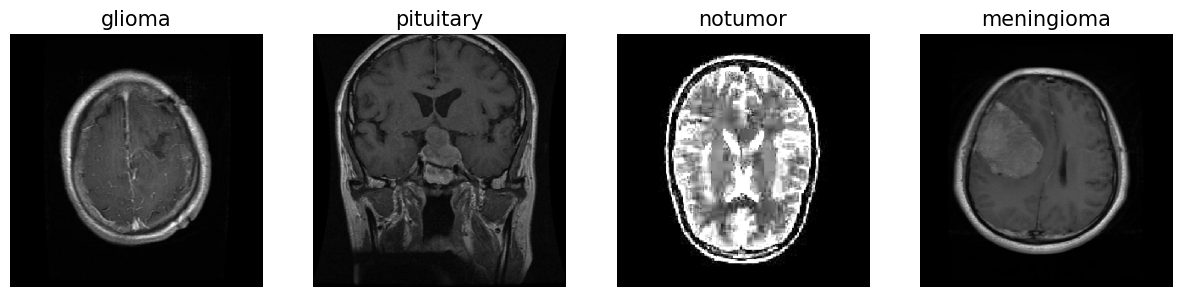

In [13]:
# Write your code below. Call the function with the right input!

plot_one_image_per_class(tr_gen)

## **🔹 Step 3: Define a model**

Note: I have already trained this model, as it takes several hours to run. The training code is commented out, but it demonstrates how to define a neural network called ResNet, a widely used architecture in image recognition.

ResNet (Residual Network) is known for its deep structure and skip connections, which help prevent vanishing gradient issues and improve accuracy in deep learning models. It is commonly used for medical imaging, object detection, and other vision tasks. It's okay, if you don't fully know about this model, it's a little complex. 

## Step 3.1 - Defining the model

Below, you will see what all different layers containing or neurons are used in the model. 

Neural networks use different types of layers, each serving a specific function. Some extract features (like ResNet50), some transform data (like Flatten), and others help prevent overfitting (like Dropout), all working together to improve learning and predictions.

For now, don’t worry about the many names you see—we won’t dive into each one. These details go beyond the scope of this class. 

But, we you look at the "build_model" function inside the "brain_tumor_utils.py", you will see that we are using ResNet50 model. It's one of the commmonly used models in image recognition tasks. 

In [15]:
# ResNet Model
model = build_model(img_shape=(299, 299, 3), learning_rate=0.001)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Step 3.2 - Training and saving the model

We have saved the trained model parameters (in file "training_history.pkl" and "brain_tumor_model.h5") so we can use it directly during the class without waiting for training to complete. 

***DO NOT COMMENT OUT the BELOW CODE! IT WILL START TRAINING THE MODEL AND WILL TAKE HOURS TO COMPLETE. ***

In [ ]:
# # Define paths
# model_path = "brain_tumor_model.h5"
# history_path = "training_history.pkl"
# csv_path = "training_history.csv"

# # Define ModelCheckpoint to save model after each epoch
# checkpoint = ModelCheckpoint(
#     model_path,
#     monitor="val_loss",
#     save_best_only=False,
#     save_weights_only=False,
#     verbose=1
# )

# # Define CSVLogger to save training history after every epoch
# csv_logger = CSVLogger(csv_path, append=True)

# # Train the model with checkpointing and logging
# hist = model.fit(
#     tr_gen,
#     epochs=10,
#     validation_data=valid_gen,
#     shuffle=False,
#     callbacks=[checkpoint, csv_logger]  # Save model & history
# )

# # Save training history separately
# with open(history_path, "wb") as f:
#     pickle.dump(hist.history, f)

# print("Training complete! Model and history saved.")

## Step 3.3 - Loading the trained model and Visualizing the performance of the model 

There are two kind of losses: -
1. Training Loss 🔄 - The error (or loss) calculated during training on the training dataset.
2. Validation Loss 🧐 - The error calculated on a separate validation dataset that the model has not seen during training.

Epochs refer to the number of times a neural network sees the entire training dataset during training. One epoch means the model has gone through all the training data once, adjusting its weights to improve predictions. More epochs allow the model to learn better, but too many can lead to overfitting. 

It’s like repeating a lesson to a child multiple times until they fully understand and remember it.

Model loaded successfully!
Training history loaded!


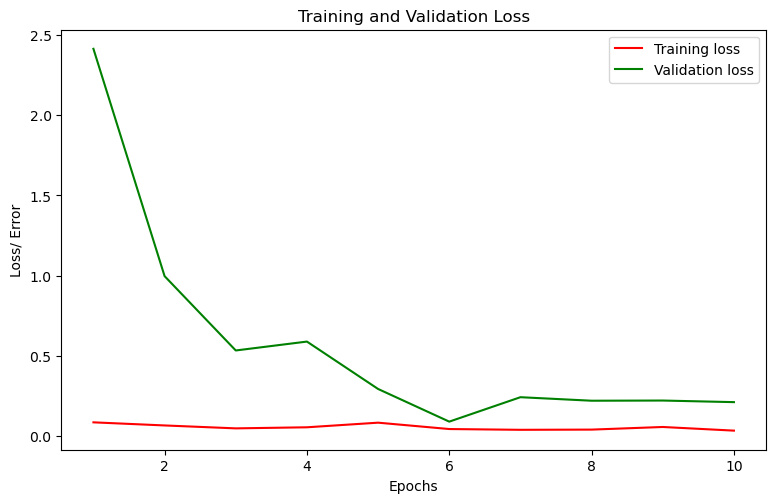

In [16]:
# Load the saved model
model = load_model("brain_tumor_model.h5")
print("Model loaded successfully!")

# Load training history
history_path = "training_history.pkl"

try:
    with open(history_path, "rb") as f:
        history = pickle.load(f)
    print("Training history loaded!")
except FileNotFoundError:
    print("No training history found. Consider re-training.")

# Now 'history' contains training metrics
if 'history' in locals():
    tr_acc = history['accuracy']
    tr_loss = history['loss']
    tr_per = history.get('precision', [])
    tr_recall = history.get('recall', [])
    val_acc = history['val_accuracy']
    val_loss = history['val_loss']
    val_per = history.get('val_precision', [])
    val_recall = history.get('val_recall', [])

    # Visualizing the metrics
    Epochs = [i + 1 for i in range(len(tr_acc))]

    plt.figure(figsize=(20, 12))
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')  # X-axis label
    plt.ylabel('Loss/ Error')  # Y-axis label
    plt.legend()
    plt.show()

## Test the model with new images

## Class Activity #3 - Test the models for new images that it hasn't seen before.

1. Go to the original database website: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data
2. Scroll down a bit and you will see "Testing" with four directories. These images are not used to train the model.
3. Copy paste the name of the image from any of these directory noting down which directory and change the below patient variables to give that image to the model. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


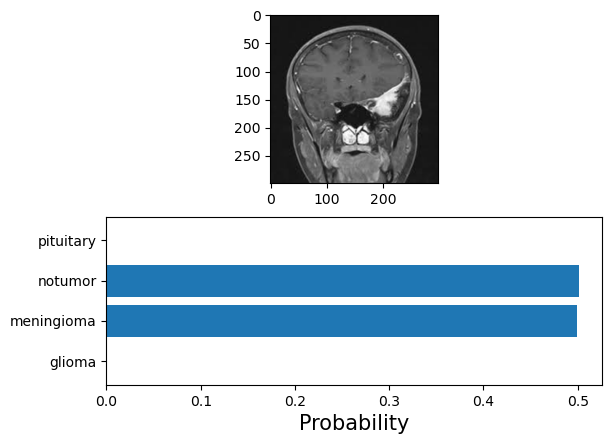

In [18]:
# Some example image locations:
# patient1 = "glioma/Te-glTr_0005.jpg"
# patient2 = "meningioma/Te-meTr_0003.jpg"
# patient3 = 'pituitary/Te-piTr_0003.jpg'

patient = "meningioma/Te-meTr_0003.jpg"
predict(path + '/Testing/' + patient, ts_gen.class_indices, model)

Wow, it really isn't sure about the `meningioma/Te-meTr_0003.jpg` file!